In [1]:
import numpy as np
import pandas as pd

In [2]:
# Specifica il percorso del file XLS
file_path =  "C:\\Users\\andre\\Desktop\\simonetti\\default of credit card clients.xls"

# Carica il file XLS utilizzando la funzione read_excel di pandas
data = pd.read_excel(file_path, header=1)

# Puoi utilizzare il dataframe 'data' per eseguire le operazioni desiderate sul file XLS


In [3]:
from sklearn.model_selection import train_test_split

X = data.iloc[:,1:24]
y = data.iloc[:,24]

X_train, X_test, y_train, y_test = train_test_split(
    X.to_numpy() , y, train_size=10000) #random_state per il set seed

In [4]:
X_train

array([[ 20000,      2,      2, ...,    623,    512,    185],
       [290000,      2,      1, ...,   5258,   1248,   9600],
       [370000,      2,      2, ...,   8817,  10763,   2526],
       ...,
       [ 80000,      2,      3, ...,      0,   6103,      0],
       [140000,      2,      1, ...,   5000,   5000,   5000],
       [ 50000,      2,      2, ...,   3003,   2800,   2504]], dtype=int64)

## SVM with cross validation
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection

In [5]:
#svm più semplice possibile ('rbf' molto più veloce)
from sklearn import svm

clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train) #fitta svm, c e gamma default
clf.score(X_test, y_test) #predict e calcolo precisione su test set

0.7793

In [6]:
#cross validation semplice
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='rbf', C=1) #prima crei il fit che vuoi applicare,random_state per il set seed, C fissato ad 1
scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1) #clf (il fit) va dentro la fun di CV, cv = 5 numero fold, acceta anche un iteratore
scores

array([0.778 , 0.778 , 0.778 , 0.7775, 0.7775])

In [7]:
#cross-validation con cv generator ShuffleSplit (che dovrebbe andare bene ma vedi anche kfold)
#ShuffleSplit è solo un modo per cv generator vedi:
#https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators (importante!)

from sklearn.model_selection import ShuffleSplit

n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3) #genera indici per dividere i dati in train e test per la cv
cross_val_score(clf, X_train, y_train, cv=cv)

array([0.79      , 0.77133333, 0.78866667, 0.78533333, 0.77766667])

In [8]:
#kfold cv con standardizzazione delle variabili (scalare le variabili potrebbe velocizzare un po')

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

clf = make_pipeline(preprocessing.StandardScaler(), 
                    svm.SVC(kernel='rbf', C=1)) #standardizza e applica il svm
cross_val_score(clf, X_train, y_train, cv=cv)

array([0.811     , 0.80433333, 0.81333333, 0.80466667, 0.81966667])

In [9]:
#la funzione cross_validate è più completa di cross_val_score, più metriche ecc...

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

#https://scikit-learn.org/stable/modules/model_evaluation.html 3.3.1.1 per altre misure di scoring
scoring = ['accuracy', 'recall','f1'] 
clf = make_pipeline(preprocessing.StandardScaler(), 
                    svm.SVC(kernel='rbf', C=1))
scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=cv,return_estimator=True) #contiene anche il modello fittato
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_recall']

In [10]:
print('precisione:',scores['test_accuracy'])
print('recall:',scores['test_recall'])
print('f1 score:',scores['test_f1'])

precisione: [0.81166667 0.818      0.809      0.81233333 0.813     ]
recall: [0.30847953 0.32041729 0.29498525 0.30955777 0.32132565]
f1 score: [0.42755826 0.44057377 0.41109969 0.43530592 0.4428997 ]


In [11]:
#rifaccio l'ultimo ma con cv con kfold

from sklearn.model_selection import KFold

#https://scikit-learn.org/stable/modules/model_evaluation.html 3.3.1.1 per altre misure di scoring
cv = KFold(n_splits=5, shuffle=True) #kfold
scoring = ['accuracy', 'recall','f1'] 
clf = make_pipeline(preprocessing.StandardScaler(), 
                    svm.SVC(kernel='rbf', C=1))
scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=cv,return_estimator=True) #contiene anche il modello fittato
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_recall']

In [12]:
print('precisione:',scores['test_accuracy'])
print('recall:',scores['test_recall'])
print('f1 score:',scores['test_f1'])

precisione: [0.8125 0.8125 0.8115 0.8275 0.811 ]
recall: [0.29333333 0.31543624 0.29478458 0.31554524 0.31788079]
f1 score: [0.41314554 0.42922374 0.40816327 0.44084279 0.43243243]


## Hyperparameter tuning
https://scikit-learn.org/stable/modules/grid_search.html#grid-search
https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# Set up possible values of parameters to optimize over
p_grid = {"C": [0.01, 0.1, 1, 10, 100], "gamma": np.logspace(-5, 0.1, 20)}

# We will use a Support Vector Classifier with "rbf" kernel
svm = svm.SVC(kernel="rbf")

nested_scores = []

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset.
# E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)

# Nested CV with parameter optimization and scaling data
clf = make_pipeline(preprocessing.StandardScaler(), 
    GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv,n_jobs=6, scoring = 'accuracy'))

#clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv,n_jobs=6, scoring = 'accuracy')
nested_score = cross_validate(clf, X=X_train, y=y_train, cv=outer_cv, n_jobs=6, return_estimator=True, scoring= 'accuracy', verbose=10)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed: 18.9min remaining: 28.3min
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed: 19.0min remaining: 12.7min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed: 19.1min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed: 19.1min finished


In [14]:
outer_models = [nested_score['estimator'][i][1] for i in range(5)]

In [15]:
[print('Best Param Outer Fold:',i,outer_models[i].best_params_) for i in range(5)]

Best Param Outer Fold: 0 {'C': 10, 'gamma': 0.016636142493842227}
Best Param Outer Fold: 1 {'C': 100, 'gamma': 0.004832930238571752}
Best Param Outer Fold: 2 {'C': 100, 'gamma': 0.0026048905108264305}
Best Param Outer Fold: 3 {'C': 10, 'gamma': 0.016636142493842227}
Best Param Outer Fold: 4 {'C': 1, 'gamma': 0.030865526123848623}


[None, None, None, None, None]

In [16]:
[print('Best Score Outer Fold:',i, outer_models[i].best_score_) for i in range(5)]

Best Score Outer Fold: 0 0.81925
Best Score Outer Fold: 1 0.8147500000000001
Best Score Outer Fold: 2 0.817375
Best Score Outer Fold: 3 0.8176249999999999
Best Score Outer Fold: 4 0.8133750000000001


[None, None, None, None, None]

In [17]:
#nested_score['estimator'][0].cv_results_
df_grid = pd.DataFrame(outer_models[0].cv_results_['params'])
df_grid['mean_test_score'] = outer_models[0].cv_results_['mean_test_score']

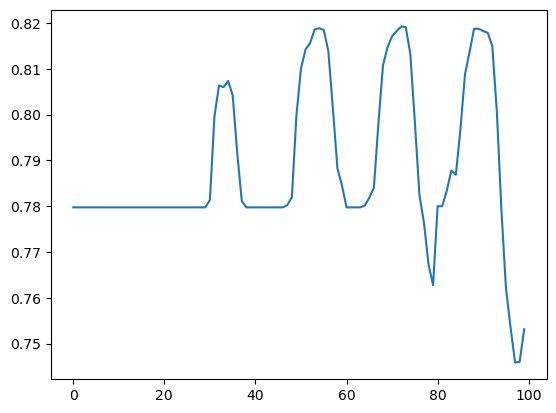

In [21]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, 100)), list(df_grid['mean_test_score']))

In [22]:
#provi i 5 modelli migliori e prendi quello che dà il risultato migliore

In [23]:
def scale_and_predict(estimator,X_test):
    
    scaler = preprocessing.StandardScaler().fit(X_test)
    X_test_scaled = scaler.transform(X_test)
    pred = estimator.predict(X_test_scaled)
    
    return pred

In [24]:
predictions = [scale_and_predict(outer_models[i],X_test) for i in range(5)] #previsioni per i 5 modelli

In [25]:
from sklearn.metrics import confusion_matrix
conf_matrices=[confusion_matrix(y_test, predictions[i]) for i in range(5)]

In [26]:
def metrics(conf_matrix):
    
    TP = conf_matrix[0,0]
    TN = conf_matrix[1,1]
    FP = conf_matrix[0,1]
    FN = conf_matrix[1,0]
    
    
    Metrics = {'Precision': TP / (TP + FP), 'Recall': TP / (TP + FN),
                'Accuracy': (TP + TN) / (TP + TN + FP + FN),
                'F1_score': 2*TP / (2*TP + FP + FN)}
    
    return Metrics 

In [27]:
[print(metrics(conf_matrices[i])['F1_score']) for i in range(5)]

0.8923736126402237
0.8921073849553558
0.8924949290060852
0.892667818214307
0.8921902034484815


[None, None, None, None, None]

In [29]:
#se si usa questo approccio bisogna rifittare tutto il train con questi parametri e usare quello
outer_models[3].best_params_

{'C': 10, 'gamma': 0.016636142493842227}

In [30]:
#altrimenti ensamble, si usano tutti e si prende il risultato che appare di più spesso

ensamble_prediction = pd.DataFrame(predictions).transpose().mode(axis = 1) #questo sceglie la previsione modale per riga

ensamble_conf_matrix = confusion_matrix(y_test,ensamble_prediction)

In [31]:
metrics(ensamble_conf_matrix)

{'Precision': 0.9607981521878609,
 'Recall': 0.8338437552202238,
 'Accuracy': 0.82025,
 'F1_score': 0.892830526158891}

In [32]:
ensamble_conf_matrix

array([[14975,   611],
       [ 2984,  1430]], dtype=int64)